In [1]:
import sys

In [2]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/gdrive')
    %cd gdrive/MyDrive/
    # ! rm -r LastFM/
    # ! git pull https://github.com/TimofeevAlex/LastFM.git
    sys.path.append('/content/gdrive/MyDrive/LastFM/src')
else:
    sys.path.append('src')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive


In [3]:
import os
import sys
from datetime import datetime
from tqdm import tqdm
tqdm.pandas()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from keras.utils.vis_utils import model_to_dot

from IPython.display import clear_output

from train_test import train_test_split
#from models import create_shallow_model
from metrics import compute_metrics
from preprocessing import build_get_negative_ratings
from neumf_helpers import create_test_step, test_one_epoch, create_train_step, train_one_epoch, validate_one_epoch, plot_metrics
%load_ext autoreload
%autoreload 2

seed=0
np.random.seed(seed)

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


### load data and set parameters

In [5]:
train = pd.read_csv('lastfm-dataset-360K/train.csv')
valid = pd.read_csv('lastfm-dataset-360K/valid.csv')
test = pd.read_csv('lastfm-dataset-360K/test.csv')

In [6]:
behav_data = pd.read_csv('lastfm-dataset-360K/behav-360k-processed.csv')
demo_data = pd.read_csv('lastfm-dataset-360K/demo-360k-processed.csv')

In [7]:
num_artists = train['artist_id'].max()
num_users = demo_data['user_email'].max()

In [35]:
batch_size = 2 ** 16
k=10
threshold = 0.1
epochs = 35

In [9]:
test_dataset = tf.data.Dataset.from_tensor_slices(test)
test_dataset = test_dataset.batch(batch_size)

## Tune hyperparameter - number of latent factors

In [10]:
factors = [20, 50, 100, 120, 160]
histories = []
precisions = []
recalls = []

labels = train.rating>=threshold
y = train.rating
weights = tf.expand_dims(1. + 0.25*y, -1)

for num_f in factors:
  model = create_shallow_model(num_f, num_users, num_artists)
  optimizer = tf.keras.optimizers.Adam()
  loss_fct = tf.keras.losses.BinaryCrossentropy(from_logits=False)
  model.compile(optimizer = optimizer, loss = loss_fct, metrics = tf.keras.metrics.RootMeanSquaredError())

  history = model.fit(x=[train.user_email, train.artist_id],
                      y=labels,
                      sample_weight=weights,
                      epochs = epochs,
                      batch_size=batch_size,
                      validation_data=([valid.user_email, valid.artist_id],
                                       valid.rating>=threshold))
  
  histories.append(history)

  # compute test loss and metrics

  test_loss_avg = tf.keras.metrics.Mean()
  test_rmse = tf.keras.metrics.RootMeanSquaredError()

  test_step = create_test_step(model, loss_fct, test_loss_avg, test_rmse)
  probs, test_loss, test_rmse = test_one_epoch(test_step, test_dataset, None, test_loss_avg, test_rmse, threshold, si=False, only_si=False)
  
  print('num_factors:', num_f)
  print('Test loss:', test_loss)
  print('Test RMSE:', test_rmse)

  pred_ratings = test.copy()
  pred_ratings['pred'] = probs
  pred_ratings_dict = {}
  for user, user_df in pred_ratings.groupby('user_email'):
    pred_ratings_dict[user] = np.stack([user_df['artist_id'].to_numpy(), user_df['pred'].to_numpy()])
  prec, rec, _, _, _  = compute_metrics(test.drop(test[test.rating == 0].index), test['user_email'].unique(), pred_ratings_dict, k)

  precisions.append(np.mean(prec))
  recalls.append(np.mean(rec))

  

Epoch 1/35
87/87 [==============================] - 12s 125ms/step - loss: 0.7946 - root_mean_squared_error: 0.5000 - val_loss: 0.6931 - val_root_mean_squared_error: 0.5000
Epoch 2/35
87/87 [==============================] - 9s 106ms/step - loss: 0.7943 - root_mean_squared_error: 0.4999 - val_loss: 0.6929 - val_root_mean_squared_error: 0.4999
Epoch 3/35
87/87 [==============================] - 10s 114ms/step - loss: 0.7911 - root_mean_squared_error: 0.4987 - val_loss: 0.6863 - val_root_mean_squared_error: 0.4966
Epoch 4/35
87/87 [==============================] - 11s 127ms/step - loss: 0.7623 - root_mean_squared_error: 0.4879 - val_loss: 0.6457 - val_root_mean_squared_error: 0.4760
Epoch 5/35
87/87 [==============================] - 9s 105ms/step - loss: 0.6804 - root_mean_squared_error: 0.4560 - val_loss: 0.5704 - val_root_mean_squared_error: 0.4376
Epoch 6/35
87/87 [==============================] - 10s 109ms/step - loss: 0.5835 - root_mean_squared_error: 0.4163 - val_loss: 0.5024 - 


Computing normalized discounted cumulative gain...



Computing hit rate...



Computing average reciprocal hit ranking...




Metrics: 

Precision @ 10: 0.3309764813181227
Recall    @ 10: 0.6723048852577282
Ndcg @ 10: 0.6958501639376902
Hit rate: 3.291449247192859
Arhr: 1.3549323516615341
Epoch 1/35
87/87 [==============================] - 20s 216ms/step - loss: 0.7946 - root_mean_squared_error: 0.5000 - val_loss: 0.6931 - val_root_mean_squared_error: 0.5000
Epoch 2/35
87/87 [==============================] - 18s 204ms/step - loss: 0.7938 - root_mean_squared_error: 0.4997 - val_loss: 0.6925 - val_root_mean_squared_error: 0.4997
Epoch 3/35
87/87 [==============================] - 18s 208ms/step - loss: 0.7864 - root_mean_squared_error: 0.4969 - val_loss: 0.6782 - val_root_mean_squared_error: 0.4925
Epoch 4/35
87/87 [==============================] - 19s 220ms/step - loss: 0.7305 - root_mean_squared_error: 0.4760 - val_loss: 0.6072 - val_root_mean_squared_error: 0.4568
Epoch 5/35
87/87 [==============================] - 18s 209ms/step - loss: 0.6139 - root_mean_squared_error: 0.4308 - val_loss: 0.5187 - val_r


Computing normalized discounted cumulative gain...



Computing hit rate...



Computing average reciprocal hit ranking...




Metrics: 

Precision @ 10: 0.3378975225393598
Recall    @ 10: 0.6865522634462426
Ndcg @ 10: 0.7054993846307075
Hit rate: 3.360196163449606
Arhr: 1.3966618026881974
Epoch 1/35
87/87 [==============================] - 33s 369ms/step - loss: 0.7946 - root_mean_squared_error: 0.5000 - val_loss: 0.6931 - val_root_mean_squared_error: 0.5000
Epoch 2/35
87/87 [==============================] - 28s 326ms/step - loss: 0.7930 - root_mean_squared_error: 0.4993 - val_loss: 0.6916 - val_root_mean_squared_error: 0.4992
Epoch 3/35
87/87 [==============================] - 32s 366ms/step - loss: 0.7777 - root_mean_squared_error: 0.4936 - val_loss: 0.6640 - val_root_mean_squared_error: 0.4853
Epoch 4/35
87/87 [==============================] - 30s 347ms/step - loss: 0.6897 - root_mean_squared_error: 0.4609 - val_loss: 0.5694 - val_root_mean_squared_error: 0.4384
Epoch 5/35
87/87 [==============================] - 32s 366ms/step - loss: 0.5627 - root_mean_squared_error: 0.4104 - val_loss: 0.4863 - val_r


Computing normalized discounted cumulative gain...



Computing hit rate...



Computing average reciprocal hit ranking...




Metrics: 

Precision @ 10: 0.3404542260365115
Recall    @ 10: 0.6921808334228157
Ndcg @ 10: 0.7072273019152255
Hit rate: 3.3855538776669705
Arhr: 1.409158489036215
Epoch 1/35
87/87 [==============================] - 38s 413ms/step - loss: 0.7946 - root_mean_squared_error: 0.5000 - val_loss: 0.6931 - val_root_mean_squared_error: 0.5000
Epoch 2/35
87/87 [==============================] - 34s 386ms/step - loss: 0.7927 - root_mean_squared_error: 0.4992 - val_loss: 0.6915 - val_root_mean_squared_error: 0.4992
Epoch 3/35
87/87 [==============================] - 35s 398ms/step - loss: 0.7754 - root_mean_squared_error: 0.4928 - val_loss: 0.6604 - val_root_mean_squared_error: 0.4835
Epoch 4/35
87/87 [==============================] - 33s 372ms/step - loss: 0.6797 - root_mean_squared_error: 0.4572 - val_loss: 0.5615 - val_root_mean_squared_error: 0.4345
Epoch 5/35
87/87 [==============================] - 35s 398ms/step - loss: 0.5524 - root_mean_squared_error: 0.4060 - val_loss: 0.4802 - val_r


Computing normalized discounted cumulative gain...



Computing hit rate...



Computing average reciprocal hit ranking...




Metrics: 

Precision @ 10: 0.3403570414006549
Recall    @ 10: 0.6920072346836248
Ndcg @ 10: 0.7086675630973511
Hit rate: 3.3844923224137675
Arhr: 1.4115536334592365
Epoch 1/35
87/87 [==============================] - 45s 499ms/step - loss: 0.7946 - root_mean_squared_error: 0.5000 - val_loss: 0.6931 - val_root_mean_squared_error: 0.5000
Epoch 2/35
87/87 [==============================] - 43s 498ms/step - loss: 0.7921 - root_mean_squared_error: 0.4989 - val_loss: 0.6910 - val_root_mean_squared_error: 0.4989
Epoch 3/35
87/87 [==============================] - 40s 458ms/step - loss: 0.7704 - root_mean_squared_error: 0.4908 - val_loss: 0.6530 - val_root_mean_squared_error: 0.4799
Epoch 4/35
87/87 [==============================] - 42s 483ms/step - loss: 0.6625 - root_mean_squared_error: 0.4509 - val_loss: 0.5493 - val_root_mean_squared_error: 0.4285
Epoch 5/35
87/87 [==============================] - 43s 489ms/step - loss: 0.5365 - root_mean_squared_error: 0.3990 - val_loss: 0.4710 - val_


Computing normalized discounted cumulative gain...



Computing hit rate...



Computing average reciprocal hit ranking...




Metrics: 

Precision @ 10: 0.34342508559723695
Recall    @ 10: 0.698107936553244
Ndcg @ 10: 0.7109856608046503
Hit rate: 3.414918589178117
Arhr: 1.4242565850005233


In [11]:
val_rmses = [histories[0].history['val_root_mean_squared_error'][-1], histories[1].history['val_root_mean_squared_error'][-1],
             histories[2].history['val_root_mean_squared_error'][-1], histories[3].history['val_root_mean_squared_error'][-1],
             histories[4].history['val_root_mean_squared_error'][-1]]

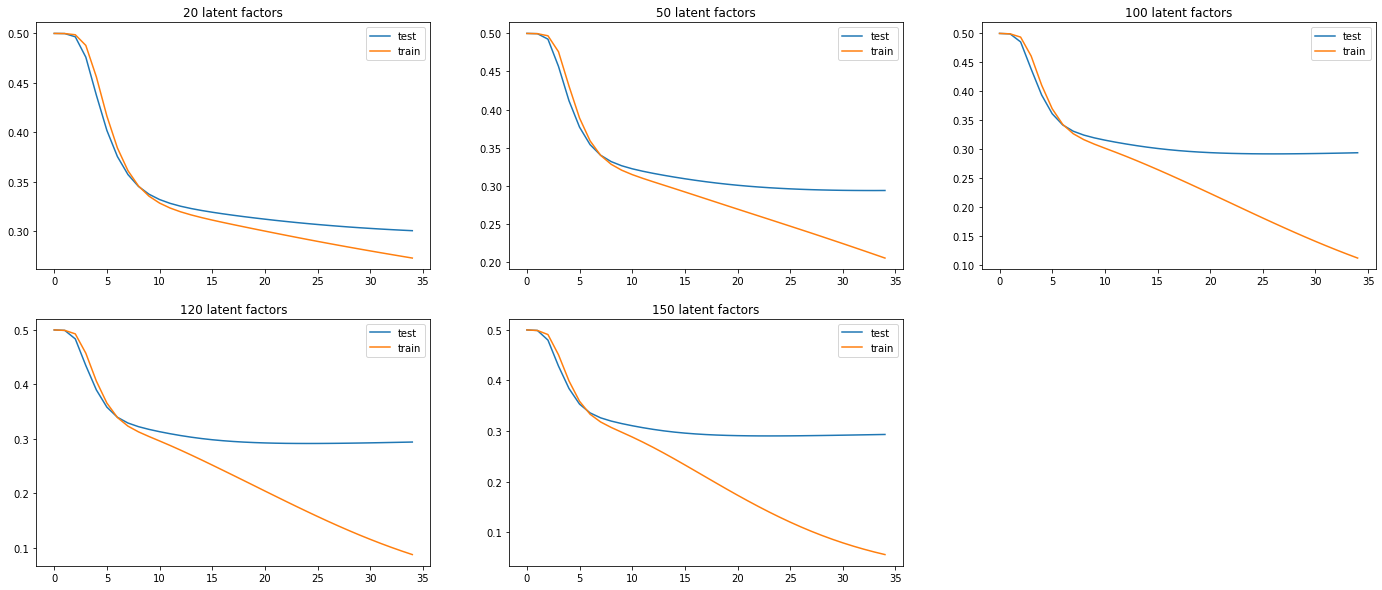

In [12]:
[20, 50, 100, 120, 160]

plt.figure(figsize=(24, 10))

plt.subplot(231)
plt.plot(list(range(epochs)), histories[0].history['val_root_mean_squared_error'], label = 'test')
plt.plot(list(range(epochs)), histories[0].history['root_mean_squared_error'], label='train')
plt.title('20 latent factors')
plt.legend()

plt.subplot(232)
plt.plot(list(range(epochs)), histories[1].history['val_root_mean_squared_error'], label = 'test')
plt.plot(list(range(epochs)), histories[1].history['root_mean_squared_error'], label='train')
plt.title('50 latent factors')
plt.legend()

plt.subplot(233)
plt.plot(list(range(epochs)), histories[2].history['val_root_mean_squared_error'], label = 'test')
plt.plot(list(range(epochs)), histories[2].history['root_mean_squared_error'], label='train')
plt.title('100 latent factors')
plt.legend()

plt.subplot(234)
plt.plot(list(range(epochs)), histories[3].history['val_root_mean_squared_error'], label = 'test')
plt.plot(list(range(epochs)), histories[3].history['root_mean_squared_error'], label='train')
plt.title('120 latent factors')
plt.legend()

plt.subplot(235)
plt.plot(list(range(35)), histories[4].history['val_root_mean_squared_error'], label = 'test')
plt.plot(list(range(35)), histories[4].history['root_mean_squared_error'], label='train')
plt.title('150 latent factors')
plt.legend()

plt.savefig('tuning_lfm')

Text(0.5, 1.0, 'recalls')

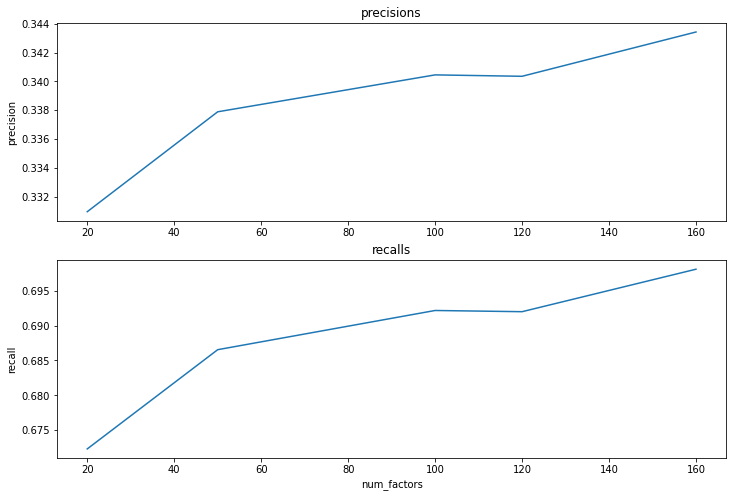

In [39]:
plt.figure(figsize=(12, 8))

plt.subplot(211)
plt.plot(factors, precisions)
plt.ylabel('precision')
plt.title('precisions')

plt.subplot(212)
plt.plot(factors, recalls)
plt.xlabel('num_factors')
plt.ylabel('recall')
plt.title('recalls')

#plt.savefig('tuning_lfm_metrics')

## Basic Experiments


In [16]:
# create model, define optimizer and loss function
model = create_shallow_model(num_factors, num_users, num_artists)
optimizer = tf.keras.optimizers.Adam()
loss_fct = tf.keras.losses.BinaryCrossentropy(from_logits=False)
model.compile(optimizer = optimizer, loss = loss_fct, metrics = tf.keras.metrics.RootMeanSquaredError())

In [17]:
# set binary labels, calculate weights
labels = train.rating>=threshold
y = train.rating
weights = tf.expand_dims(1. + 0.25*y, -1)

# fit model
history = model.fit(x=[train.user_email, train.artist_id],
                      y=labels,
                      sample_weight=weights,
                      epochs = 35,
                      batch_size=batch_size,
                      validation_data=([valid.user_email, valid.artist_id],
                                       valid.rating>=threshold))


avg_test_loss = tf.keras.metrics.Mean()
test_rmse = tf.keras.metrics.RootMeanSquaredError()

test_step = create_test_step(model, loss_fct, avg_test_loss, test_rmse)
probs, test_loss, test_rmse = test_one_epoch(test_step, test_dataset, None, test_loss_avg, test_rmse, threshold, si=False, only_si=False)
print('Test loss:', test_loss)
print('Test RMSE:', test_rmse)

pred_ratings = test.copy()
pred_ratings['pred'] = probs
pred_ratings_dict = {}
for user, user_df in pred_ratings.groupby('user_email'):
  pred_ratings_dict[user] = np.stack([user_df['artist_id'].to_numpy(), user_df['pred'].to_numpy()])
prec, rec, _, _, _  = compute_metrics(test.drop(test[test.rating == 0].index), test['user_email'].unique(), pred_ratings_dict, k)

Epoch 1/35
87/87 [==============================] - 45s 501ms/step - loss: 0.7947 - root_mean_squared_error: 0.5000 - val_loss: 0.6931 - val_root_mean_squared_error: 0.5000
Epoch 2/35
87/87 [==============================] - 42s 479ms/step - loss: 0.7921 - root_mean_squared_error: 0.4990 - val_loss: 0.6911 - val_root_mean_squared_error: 0.4990
Epoch 3/35
87/87 [==============================] - 42s 488ms/step - loss: 0.7711 - root_mean_squared_error: 0.4911 - val_loss: 0.6548 - val_root_mean_squared_error: 0.4807
Epoch 4/35
87/87 [==============================] - 44s 507ms/step - loss: 0.6664 - root_mean_squared_error: 0.4523 - val_loss: 0.5525 - val_root_mean_squared_error: 0.4302
Epoch 5/35
87/87 [==============================] - 44s 499ms/step - loss: 0.5399 - root_mean_squared_error: 0.4006 - val_loss: 0.4734 - val_root_mean_squared_error: 0.3856
Epoch 6/35
87/87 [==============================] - 42s 487ms/step - loss: 0.4608 - root_mean_squared_error: 0.3601 - val_loss: 0.4218 


Computing normalized discounted cumulative gain...



Computing hit rate...



Computing average reciprocal hit ranking...




Metrics: 

Precision @ 10: 0.3438198047336394
Recall    @ 10: 0.6987791645331677
Ndcg @ 10: 0.7113697110447625
Hit rate: 3.418940537954338
Arhr: 1.4270315860744278


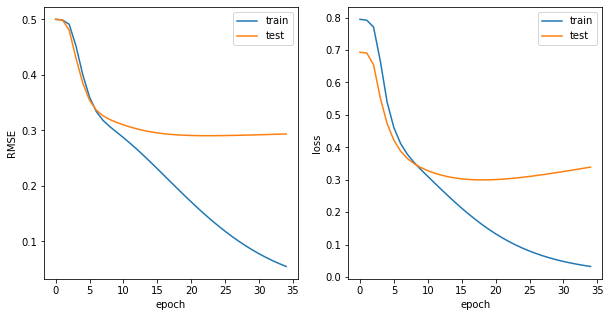

In [18]:
fig = plt.figure(figsize=(12, 8))
fig.suptitle('LFM Training Metrics with 3x Negative Samples')

plt.subplot(211)
plt.plot(list(range(epochs)), history.history['loss'], label = 'Train')
plt.plot(list(range(epochs)), history.history['val_loss'], label = 'Validation')
plt.ylabel('Loss')
plt.legend()

plt.subplot(212)
plt.plot(list(range(epochs)), history.history['root_mean_squared_error'], label = 'Train')
plt.plot(list(range(epochs)), history.history['val_root_mean_squared_error'], label = 'Validation')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend()

plt.savefig('plots/basic_exp')

## Negative samples x0.5

In [19]:
negative_train = train[train['rating'] == 0]
negative_train = negative_train.sample(negative_train.shape[0] // 2)
train_half = train.drop(negative_train.index)

In [20]:
model = create_shallow_model(num_factors, num_users, num_artists)
optimizer = tf.keras.optimizers.Adam()
loss_fct = tf.keras.losses.BinaryCrossentropy(from_logits=False)
model.compile(optimizer = optimizer, loss = loss_fct, metrics = tf.keras.metrics.RootMeanSquaredError())

In [21]:
# set binary labels, calculate weights
labels = train_half.rating>=threshold
y = train_half.rating
weights = tf.expand_dims(1. + 0.25*y, -1)

# fit model
history = model.fit(x=[train_half.user_email, train_half.artist_id],
                      y=labels,
                      sample_weight=weights,
                      epochs = 35,
                      batch_size=batch_size,
                      validation_data=([valid.user_email, valid.artist_id],
                                       valid.rating>=threshold))


avg_test_loss = tf.keras.metrics.Mean()
test_rmse = tf.keras.metrics.RootMeanSquaredError()

test_step = create_test_step(model, loss_fct, avg_test_loss, test_rmse)
probs, test_loss, test_rmse = test_one_epoch(test_step, test_dataset, None, test_loss_avg, test_rmse, threshold, si=False, only_si=False)
print('Test loss:', test_loss)
print('Test RMSE:', test_rmse)

pred_ratings = test.copy()
pred_ratings['pred'] = probs
pred_ratings_dict = {}
for user, user_df in pred_ratings.groupby('user_email'):
  pred_ratings_dict[user] = np.stack([user_df['artist_id'].to_numpy(), user_df['pred'].to_numpy()])
prec, rec, _, _, _  = compute_metrics(test.drop(test[test.rating == 0].index), test['user_email'].unique(), pred_ratings_dict, k)

Epoch 1/35
64/64 [==============================] - 35s 518ms/step - loss: 0.8311 - root_mean_squared_error: 0.5000 - val_loss: 0.6931 - val_root_mean_squared_error: 0.5000
Epoch 2/35
64/64 [==============================] - 32s 501ms/step - loss: 0.8289 - root_mean_squared_error: 0.4991 - val_loss: 0.6923 - val_root_mean_squared_error: 0.4996
Epoch 3/35
64/64 [==============================] - 32s 506ms/step - loss: 0.8167 - root_mean_squared_error: 0.4946 - val_loss: 0.6780 - val_root_mean_squared_error: 0.4924
Epoch 4/35
64/64 [==============================] - 32s 498ms/step - loss: 0.7412 - root_mean_squared_error: 0.4671 - val_loss: 0.6123 - val_root_mean_squared_error: 0.4600
Epoch 5/35
64/64 [==============================] - 32s 500ms/step - loss: 0.6006 - root_mean_squared_error: 0.4171 - val_loss: 0.5437 - val_root_mean_squared_error: 0.4268
Epoch 6/35
64/64 [==============================] - 33s 516ms/step - loss: 0.5094 - root_mean_squared_error: 0.3836 - val_loss: 0.5038 


Computing normalized discounted cumulative gain...



Computing hit rate...



Computing average reciprocal hit ranking...




Metrics: 

Precision @ 10: 0.3259961425175306
Recall    @ 10: 0.6630478162216421
Ndcg @ 10: 0.703155461232349
Hit rate: 3.2422140155196386
Arhr: 1.36359235115366


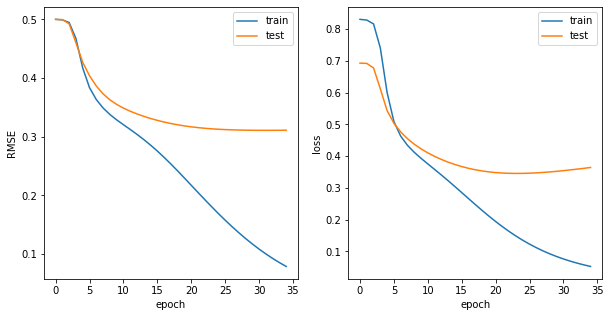

In [22]:
fig = plt.figure(figsize=(12, 8))
fig.suptitle('LFM Training Metrics with 3x Negative Samples')

plt.subplot(211)
plt.plot(list(range(epochs)), history.history['loss'], label = 'Train')
plt.plot(list(range(epochs)), history.history['val_loss'], label = 'Validation')
plt.ylabel('Loss')
plt.legend()

plt.subplot(212)
plt.plot(list(range(epochs)), history.history['root_mean_squared_error'], label = 'Train')
plt.plot(list(range(epochs)), history.history['val_root_mean_squared_error'], label = 'Validation')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend()

plt.savefig('plots/05_neg_exp')

## Negative samples x2

In [23]:
train_twice = pd.read_csv('lastfm-dataset-360K/train_twice.csv')

In [24]:
model = create_shallow_model(num_factors, num_users, num_artists)
optimizer = tf.keras.optimizers.Adam()
loss_fct = tf.keras.losses.BinaryCrossentropy(from_logits=False)
model.compile(optimizer = optimizer, loss = loss_fct, metrics = tf.keras.metrics.RootMeanSquaredError())

In [25]:
# set binary labels, calculate weights
labels = train_twice.rating>=threshold
y = train_twice.rating
weights = tf.expand_dims(1. + 0.25*y, -1)

# fit model
history = model.fit(x=[train_twice.user_email, train_twice.artist_id],
                      y=labels,
                      sample_weight=weights,
                      epochs = 35,
                      batch_size=batch_size,
                      validation_data=([valid.user_email, valid.artist_id],
                                       valid.rating>=threshold))


avg_test_loss = tf.keras.metrics.Mean()
test_rmse = tf.keras.metrics.RootMeanSquaredError()

test_step = create_test_step(model, loss_fct, avg_test_loss, test_rmse)
probs, test_loss, test_rmse = test_one_epoch(test_step, test_dataset, None, test_loss_avg, test_rmse, threshold, si=False, only_si=False)
print('Test loss:', test_loss)
print('Test RMSE:', test_rmse)

pred_ratings = test.copy()
pred_ratings['pred'] = probs
pred_ratings_dict = {}
for user, user_df in pred_ratings.groupby('user_email'):
  pred_ratings_dict[user] = np.stack([user_df['artist_id'].to_numpy(), user_df['pred'].to_numpy()])
prec, rec, _, _, _  = compute_metrics(test.drop(test[test.rating == 0].index), test['user_email'].unique(), pred_ratings_dict, k)

Epoch 1/35
130/130 [==============================] - 66s 491ms/step - loss: 0.7608 - root_mean_squared_error: 0.5000 - val_loss: 0.6931 - val_root_mean_squared_error: 0.5000
Epoch 2/35
130/130 [==============================] - 64s 495ms/step - loss: 0.7568 - root_mean_squared_error: 0.4984 - val_loss: 0.6838 - val_root_mean_squared_error: 0.4953
Epoch 3/35
130/130 [==============================] - 63s 482ms/step - loss: 0.6968 - root_mean_squared_error: 0.4747 - val_loss: 0.5592 - val_root_mean_squared_error: 0.4328
Epoch 4/35
130/130 [==============================] - 63s 482ms/step - loss: 0.5138 - root_mean_squared_error: 0.3888 - val_loss: 0.4161 - val_root_mean_squared_error: 0.3516
Epoch 5/35
130/130 [==============================] - 62s 481ms/step - loss: 0.3765 - root_mean_squared_error: 0.3126 - val_loss: 0.3580 - val_root_mean_squared_error: 0.3244
Epoch 6/35
130/130 [==============================] - 64s 496ms/step - loss: 0.3226 - root_mean_squared_error: 0.2884 - val_l


Computing normalized discounted cumulative gain...



Computing hit rate...



Computing average reciprocal hit ranking...




Metrics: 

Precision @ 10: 0.3582748979561323
Recall    @ 10: 0.728083606521513
Ndcg @ 10: 0.7204528905110785
Hit rate: 3.5627887505046125
Arhr: 1.4827635335240006


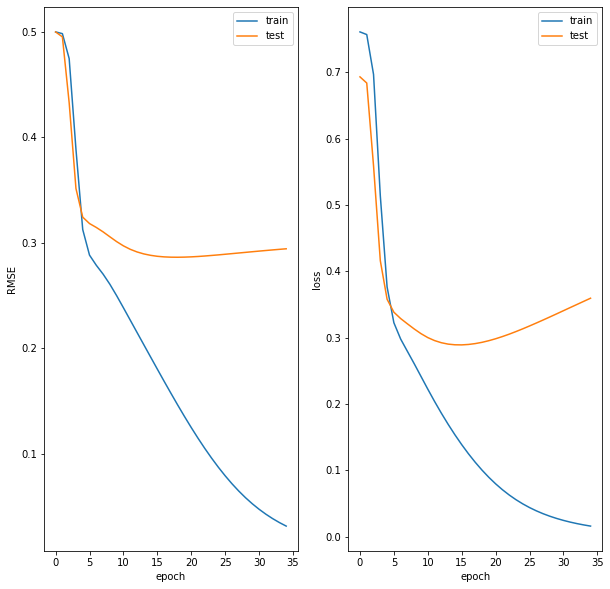

In [26]:
fig = plt.figure(figsize=(12, 8))
fig.suptitle('LFM Training Metrics with 3x Negative Samples')

plt.subplot(211)
plt.plot(list(range(epochs)), history.history['loss'], label = 'Train')
plt.plot(list(range(epochs)), history.history['val_loss'], label = 'Validation')
plt.ylabel('Loss')
plt.legend()

plt.subplot(212)
plt.plot(list(range(epochs)), history.history['root_mean_squared_error'], label = 'Train')
plt.plot(list(range(epochs)), history.history['val_root_mean_squared_error'], label = 'Validation')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend()

plt.savefig('plots/2_neg_exp')

## Negative samples x3

In [27]:
del train_twice
train_triple = pd.read_csv('lastfm-dataset-360K/train_triple.csv')

In [30]:
model = create_shallow_model(num_factors, num_users, num_artists)
optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
model.compile(optimizer = optimizer, loss = loss_fct, metrics = tf.keras.metrics.RootMeanSquaredError())

In [31]:
# set binary labels, calculate weights
labels = train_triple.rating>=threshold
y = train_triple.rating
weights = tf.expand_dims(1. + 0.25*y, -1)

# fit model
history = model.fit(x=[train_triple.user_email, train_triple.artist_id],
                      y=labels,
                      sample_weight=weights,
                      epochs = 35,
                      batch_size=batch_size,
                      validation_data=([valid.user_email, valid.artist_id],
                                       valid.rating>=threshold))


avg_test_loss = tf.keras.metrics.Mean()
test_rmse = tf.keras.metrics.RootMeanSquaredError()

test_step = create_test_step(model, loss_fct, avg_test_loss, test_rmse)
probs, test_loss, test_rmse = test_one_epoch(test_step, test_dataset, None, test_loss_avg, test_rmse, threshold, si=False, only_si=False)
print('Test loss:', test_loss)
print('Test RMSE:', test_rmse)

pred_ratings = test.copy()
pred_ratings['pred'] = probs
pred_ratings_dict = {}
for user, user_df in pred_ratings.groupby('user_email'):
  pred_ratings_dict[user] = np.stack([user_df['artist_id'].to_numpy(), user_df['pred'].to_numpy()])
prec, rec, _, _, _  = compute_metrics(test.drop(test[test.rating == 0].index), test['user_email'].unique(), pred_ratings_dict, k)

Epoch 1/35
173/173 [==============================] - 88s 497ms/step - loss: 0.7439 - root_mean_squared_error: 0.5000 - val_loss: 0.6930 - val_root_mean_squared_error: 0.4999
Epoch 2/35
173/173 [==============================] - 86s 498ms/step - loss: 0.7366 - root_mean_squared_error: 0.4970 - val_loss: 0.6628 - val_root_mean_squared_error: 0.4847
Epoch 3/35
173/173 [==============================] - 86s 499ms/step - loss: 0.5998 - root_mean_squared_error: 0.4351 - val_loss: 0.4409 - val_root_mean_squared_error: 0.3663
Epoch 4/35
173/173 [==============================] - 87s 501ms/step - loss: 0.3527 - root_mean_squared_error: 0.2992 - val_loss: 0.3553 - val_root_mean_squared_error: 0.3268
Epoch 5/35
173/173 [==============================] - 82s 474ms/step - loss: 0.2785 - root_mean_squared_error: 0.2653 - val_loss: 0.3433 - val_root_mean_squared_error: 0.3240
Epoch 6/35
173/173 [==============================] - 81s 470ms/step - loss: 0.2572 - root_mean_squared_error: 0.2575 - val_l


Computing normalized discounted cumulative gain...



Computing hit rate...



Computing average reciprocal hit ranking...




Metrics: 

Precision @ 10: 0.36629188284018366
Recall    @ 10: 0.7443356316868645
Ndcg @ 10: 0.7260685430923594
Hit rate: 3.642495103389501
Arhr: 1.514682302357222


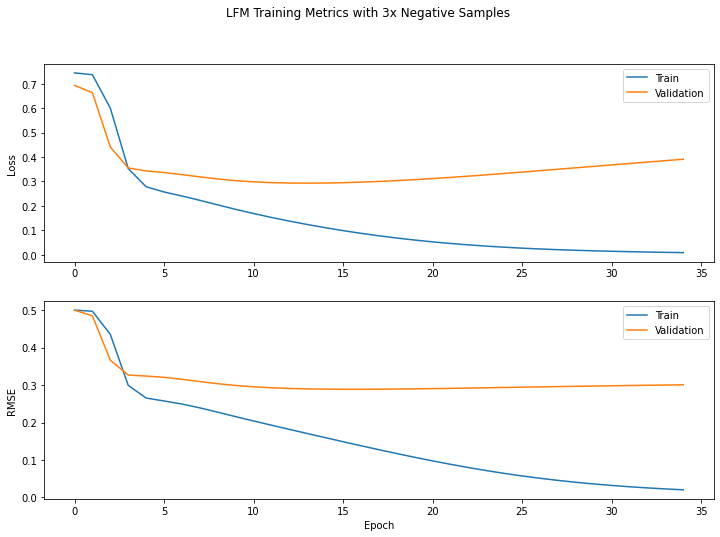

In [37]:
fig = plt.figure(figsize=(12, 8))
fig.suptitle('LFM Training Metrics with 3x Negative Samples')

plt.subplot(211)
plt.plot(list(range(epochs)), history.history['loss'], label = 'Train')
plt.plot(list(range(epochs)), history.history['val_loss'], label = 'Validation')
plt.ylabel('Loss')
plt.legend()

plt.subplot(212)
plt.plot(list(range(epochs)), history.history['root_mean_squared_error'], label = 'Train')
plt.plot(list(range(epochs)), history.history['val_root_mean_squared_error'], label = 'Validation')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend()



plt.savefig('plots/3_neg_exp')